In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

In [63]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

### data summary
- There are 68211 total records, after filtering by duration > 1 & <=60 there will be 65924 records, which is 96% of the data

In [ ]:
df = pd.read_parquet("../data/green_tripdata_2023-01.parquet")

df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/60)

categorical = ['PULocationID','DOLocationID',]
numerical = ['trip_distance']
df[categorical]= df[categorical].astype(str)
df = df[(df.duration > 1) & (df.duration <=60)]

In [11]:
"""excuting the above line(df[categorical]= df[categorical].astype(str))would issue 
a warning "trying to modify on a copy of DataFrame instead the original object"""
df = df[(df.duration > 1) & (df.duration <=60)]

In [ ]:
train_dict = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

target = 'duration'
y_train = df[target].values
#training
Lr = LinearRegression()
Lr.fit(X_train,y_train)
#prediction
y_pred = Lr.predict(X_train)
#evaluation
mean_squared_error(y_train,y_pred, squared=False)

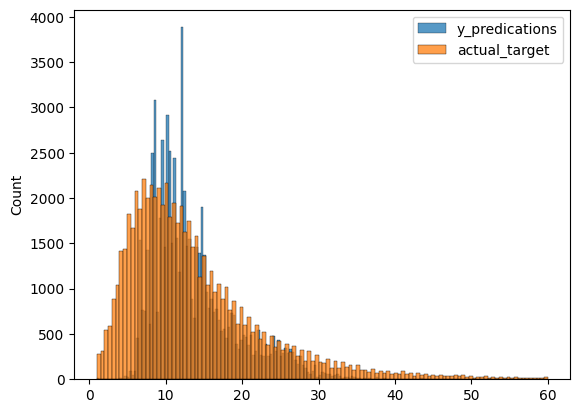

In [37]:
sns.histplot(y_pred, label = "y_predications")
sns.histplot(y_train, label = "actual_target")

plt.legend()

/tmp/ipykernel_192787/1815305283.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = "y_predications")
/tmp/ipykernel_192787/1815305283.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label = "actual_target")


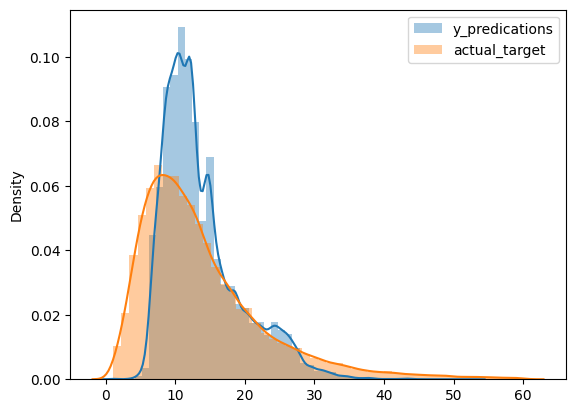

In [40]:
sns.distplot(y_pred, label = "y_predications")
sns.distplot(y_train, label = "actual_target")

plt.legend()


In [53]:
#evaluation
mean_squared_error(y_train,y_pred, squared=False) # squared=False ->the Root Mean Squared Error

7.056709895880186

- Initial base model gives us RMSE of 7.05, our model is off by this amount from the actual duration or time

In [50]:
def read_and_preprocess(filename):
    df = pd.read_parquet(filename)
    
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/60)
    
    categorical = ['PULocationID','DOLocationID',]
    
    df[categorical]= df[categorical].astype(str)
    df = df[(df.duration > 1) & (df.duration <=60)]
    return df

In [51]:
df_train = read_and_preprocess('../data/green_tripdata_2023-01.parquet')
df_valid = read_and_preprocess('../data/green_tripdata_2023-02.parquet')

In [52]:
len(df_train),len(df_valid)

(65924, 62547)

### Training pipeline

In [60]:
dv = DictVectorizer()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_valid[categorical + numerical].to_dict(orient='records')
x_val = dv.transform(val_dict)

In [61]:

target = 'duration'
y_train = df_train[target].values
y_valid = df_valid[target].values

In [62]:

#training
Lr = LinearRegression()
Lr.fit(X_train,y_train)
#prediction
y_pred = Lr.predict(x_val)
#evaluation
mean_squared_error(y_valid,y_pred, squared=False)

7.3517729073485345

## with Lasso Reg

In [64]:
#With Lasso
Lr = Lasso()
Lr.fit(X_train,y_train)
#prediction
y_pred = Lr.predict(x_val)
#evaluation
mean_squared_error(y_valid,y_pred, squared=False)

9.320127565332573